규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷
===========================================
규제 선형 모델의 개요
------------------------
최적 모델을 위한 비용함수 구성요소
- 학습 데이터 잔차 오류 최소화 (RSS 최소화 방법)
- 과적합 방지 위한 회귀계수 크기 제어

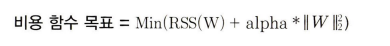

위 식을 최소화해서 과적합 개선하기!

alpha : 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터
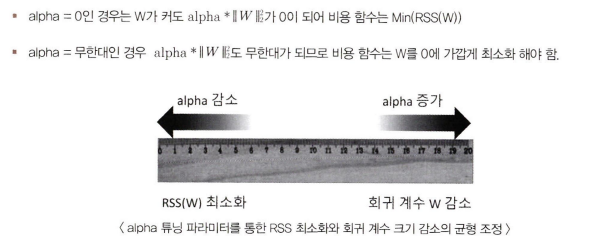

규제(regularization) : 비용 함수에 alpha 값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식
- L2 규제 - W^2에 페널티 부여 / 릿지(Ridge) 회귀
- L1 규제 - W의 절댓값에 페널티 부여 / 라쏘(Lasso) 회귀

릿지 회귀
--------------
사이킷런의 Ridge 클래스로 구현

Ridge 클래스의 주요 생성 파라미터 : alpha (릿지 회귀의 alpha L2 규제 계수)

In [ ]:
# pg.321 : 보스턴 주택 가격을 Ridge 클래스 이용해서 다시 예측 + 성능 평가

import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])

feature_names=['CRIM',	'ZN',	'INDUS',	'CHAS',	'NOX',	'RM',	'AGE',	'DIS',	'RAD',	'TAX'	,'PTRATIO',	'B'	,'LSTAT',	'PRICE']
bostonDF = pd.DataFrame(boston, columns=feature_names)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha=10으로 설정해 릿지 회귀 수행
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

앞 예제의 규제가 없는 LinearRegression의 RMSE 평균보다 더 뛰어난 예측 성능을 보여줌

In [ ]:
# pg.322 : 릿지의 alpha값을 0,0.1,1,10,100으로 변화시키면서 RMSE와 회귀 계수 값의 변화를 살펴보기

# Ridge에 사용될 alpha 파라미터의 값들을 정의
alphas = [0 , 0.1 , 1 , 10 , 100]

# alphas list 값을 iteration하면서 alpha에 따른 평균 rmse 구함.
for alpha in alphas :
    ridge = Ridge(alpha = alpha)
    
    #cross_val_score를 이용하여 5 fold의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha,avg_rmse))

alpha가 100일 때 RMSE가 5.330으로 가장 좋음

In [ ]:
# pg.323 : alpha값의 변화에 따른 피처의 회귀 계수 값을 가로 막대 그래프로 시각화하기

import matplotlib.pyplot as plt
import seaborn as sns

# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성  
fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성  
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.  
    coeff = pd.Series(data=ridge.coef_ , index=X_data.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

alpha 값을 계속 증가시킬수록 회귀 계수 값은 지속적으로 작아짐

In [ ]:
# pg.324 : 데이터프렝ㅁ에 저장된 alpha값의 변화에 따른 릿지 회귀 계수 값 구하기

ridge_alphas = [0 , 0.1 , 1 , 10 , 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

alpha값이 증가하면서 회귀 계수는 지속적으로 작아지고 있지만, 릿지 회귀의 경우 회귀 계수를 0으로 만들지는 않음

라쏘 회귀
--------------
라소 회귀 : W의 절댓값에 페널티를 부여하는 L1 규제를 선형 회귀에 적용한 것
- 사이킷런의 Lasso 클래스로 구현
- Lasso 클래스의 주요 생성 파라미터 : alpha (라쏘 회귀의 alpha L1 규제 계수)

L1 규제 : alpha*||W||22 
- 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거함
- 적절한 피처만 회귀에 포함시키는 피처 선택의 특성을 가짐

In [ ]:
# pg.325 : 라쏘의 alpha값을 변화시키면서 RMSE와 각 피처의 회귀 계수 출력하기

# get_linear_reg_eval() 함수 : alpha값에 따른 폴드 평균 RMSE를 출력하고 회귀 계수값들을 데이터프레임으로 반환함

from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환 
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso': model = Lasso(alpha=param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, 
                                             y_target_n, scoring="neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(X_data , y_target)
        
        # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
        coeff = pd.Series(data=model.coef_ , index=X_data.columns )
        colname='alpha:'+str(param)
        coeff_df[colname] = coeff
    return coeff_df
# end of get_linear_regre_eval

In [ ]:
# pg.326 : 위에서 만든 함수 이용해서 alpha값의 변화에 따른 RMSE와 그때의 회귀계수들 출력하기

# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df =get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

alpha가 0.07일 때 가장 좋은 평균 RMSE를 보여줌

In [ ]:
# pg.326 : alpha값에 따른 피처별 회귀 계수 출력하기

# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

- alpha 크기 증가함에 따라 일부 피처의 회귀 계수는 아예 0으로 바뀜
- 회귀계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻을 수 있음


엘라스틱넷 회귀
----------------
엘라스틱넷(Elastic Net)회귀 : L2규제와 L1규제를 결합한 회귀
- 비용함수의 목표 : RSS(W) + alpha2*||W||22 + alpha1*||W||1을 최소화하는 W 찾기
- L2 규제를 라쏘 회귀에 추가한 것
- 단점 : L1, L2 규제가 결합된 규제로 인해 수행시간이 상대적으로 오래 걸림
- 사이킷런의 ElasticNet 클래스로 구현
- ElasticNet 클래스의 주요 생성 파라미터 : alpha, I1_ratio
  - 엘라스틱넷의 규제 : a*L1 + b*L2 (a : L1 규제의 alpha값, b : L2 규제의 alpha값)
  - alpha : a+b
  - I1_ratio : a/(a+b)       -> 0(1)이면 L2(L1)규제와 동일



In [ ]:
# pg.327 : ElasticNet 클래스 이용해서 엘라스틱넷 alpha 값을 변화시키면서 RMSE와 각 피처의 회귀 계수 출력하기

# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정 (단순히 alpha값의 변화만 살피기 위함이니깐 미리 고정함)
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df =get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                      X_data_n=X_data, y_target_n=y_target)

In [ ]:
# 반환된 coeff_elastic_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

- alpha가 0.5일 때 가장 좋은 RMSE를 보여줌
- alpha값에 따른 피처들의 회귀 계수들 값이 라쏘보다는 상대적으로 0이 되는 값이 적음을 알 수 있음

규제 선형 회귀 중에서 어떤 것이 가장 좋은지는 상황에 따라 다름

선형 회귀 모델을 위한 데이터 변환
-----------------------------------------
선형 회귀 모델 적용하기 전에 먼저 데이터에 대한 스케일링/정규화 작업 수행하는 것이 일반적
- 스케일링/정규화 작업 선행한다고 해서 무조건 예측 성능이 향상되는 것은 아님
- 중요 피처들이나 타깃값의 분포도가 심하게 왜곡됐을 경우에 변환 작업 수행
-


사이킷런 이용해서 피처 데이터 세트에 적용하는 변환작업의 방법

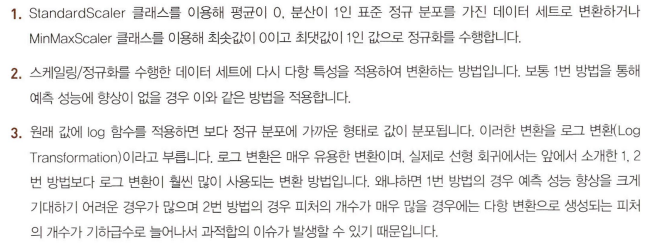

타깃값 : 일반적으로 로그 변환 적용

In [ ]:
# pg.330 : 보스턴 주택가격 피처 데이터 세트에 표준 정규 분포 변환, 최댓값/최솟값 정규화, 로그 변환 적용하기
# RMSE로 각 경우별 예측 성능 측정하기

# get_scaled_data()함수 : method 인자로 변환방법을 결정
#                       : p_degree : 다항식 특성을 추가할 때 다항식 차수가 입력됨 (2를 안 넘김)
#                       : 로그 변환이면 np.log1p()이용 (언더플로우 방지 목적... - 다음장에서 자세히..)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다향식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음. 
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, 
                                         include_bias=False).fit_transform(scaled_data)
    return scaled_data

In [ ]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변환. 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화 + 다항식 특성, 로그변환
# (None, None) : 아무 변환 안한 원본 데이터
# ('Standard', None) : 표준 정규 분포
# ('Standard', 2) : 표준 정규 분포를 다시 2차 다항식 변환
#  ('MinMax', None) : 최솟값/최댓값 정규화
# ('MinMax', 2) : 최솟값/최댓값 정규화를 다시 2차 다항식 변환
# ('Log', None) : 로그 변환
scale_methods=[(None, None), ('Standard', None), ('Standard', 2), 
               ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], 
                                    input_data=X_data)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, 
                        y_target_n=y_target, verbose=False)

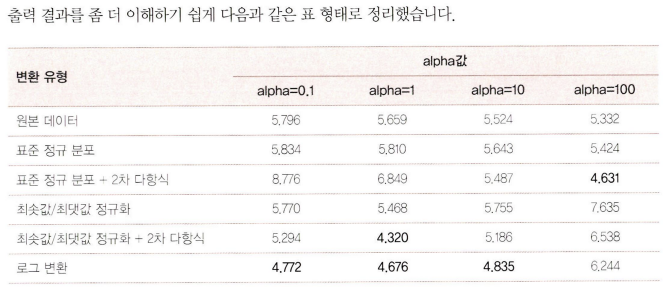

다항식 변환 : 피처의 개수가 많으면 적용하기 어려움 , 뎅터 건수가 많으면 계산시간 오래 걸림 -> 한계 있음

로그 변환 : 모든 alpha값에서 좋은 성능 향상이 일어남
- 선형회귀를 적용하려는 데이터 세트에 데이터 값의 분포가 심하게 왜곡되어 있는 경우 로그 변환 적용하면 good

로지스틱 회귀
================
로지스틱 회귀
- 선형 회귀 방식을 분류에 적용한 알고리즘
- 시그모이드(Sigmoid)함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정
  - 선형회귀 : 학습을 통해 선형 함수의 최적선을 찾음

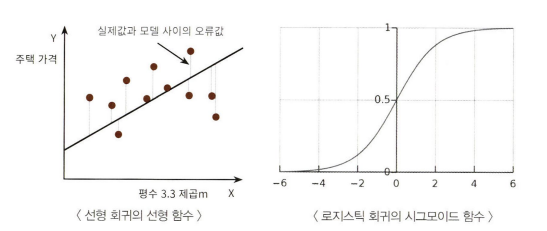

시그모이드 함수 : y = 1 / ( 1+e^(-x) )
- y값은 항상 0과 1사이를 반환
- x값이 커지면 1에 근사, 작아지면 0에 근사

로지스틱 회귀 : 선형 회귀 방식을 기반으로 하되 시그모이드 함수를 이용해 분류를 수행하는 회귀

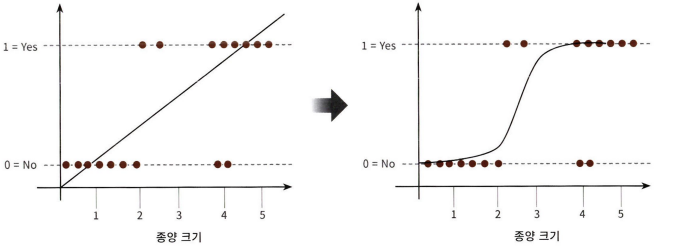

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [ ]:
# 학습,테스트 데이터 세트로 나누기 + 로지스틱 회귀로 분류 수행하기

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 로지스틱 회귀 : 데이터의 정규 분포도에 따라 예측 성능에 영향 받음 -> 스케일링 적용하고 데이터세트 분리해주기
# StandardScaler( )로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train , X_test, y_train , y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

# accuracy와 roc_auc 측정
print('accuracy: {:0.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_test , lr_preds)))

사이킷런 LogisticRegression클래스의 주요 하이퍼 파라미터
- penalty : 규제의 유형 설정 (기본 : l2)
- c : 규제 강도를 조절하는 alpha값의 역수 / 작을수록 규제 강도 셈

In [ ]:
from sklearn.model_selection import GridSearchCV

params={'penalty':['l2', 'l1'],
        'C':[0.01, 0.1, 1, 1, 5, 10]}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3 )
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, 
                                                  grid_clf.best_score_))

로지스틱 회귀의 장점
- 가볍고 빠름
- 이진 분류 예측 성능 뛰어남
- 희소한 데이터 세트 분류에도 뛰어난 성능을 보여주어 텍스트 분류에도 자주 사용됨

회귀 트리
==========
회귀 트리 : 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산함
- 분류 트리 : 특정 레이블을 결정함

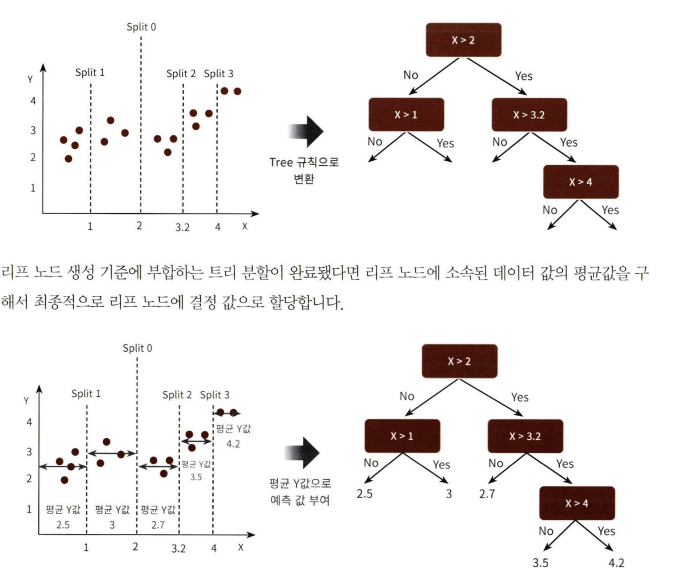

모든 트리 기반의 알고리즘 : 분류, 회귀 둘다 가능
- 트리생성이 CART 알고리즘에 기반하기 때문
- CART(Classification And Regression Trees) : 회귀, 분류를 가능하게 해주는 트리 생성 알고리즘

사이킷런의 트리 기반 회귀와 분류의 Estimator 클래스
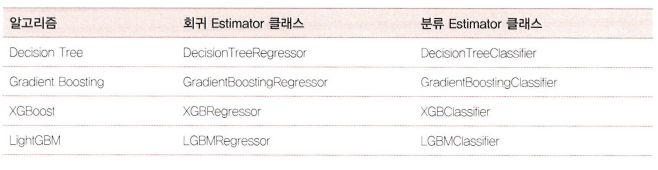

In [ ]:
# pg.337 : RandomForestRegressor 이용해서 보스턴 주택 가격 예측 수행하기

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])

feature_names=['CRIM',	'ZN',	'INDUS',	'CHAS',	'NOX',	'RM',	'AGE',	'DIS',	'RAD',	'TAX'	,'PTRATIO',	'B'	,'LSTAT',	'PRICE']
bostonDF = pd.DataFrame(boston, columns=feature_names)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [ ]:
# pg.338 : GBM, XGBoost, LightGBM의 Regressor를 모두 이용해서 보스턴 주택 가격 예측 수행하기
# get_model_cv_prediction()함수 : 입력 모델과 데이터 세트를 입력 받아 교차 검증으로 평균 RMSE를 계산해주는 함수

def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ',model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [ ]:
# 다양한 유형의 회귀 트리 생성 + 보스턴 주택 가격 예측하기

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:  
    get_model_cv_prediction(model, X_data, y_target)

회귀 트리 Regressor 클래스 : 회귀 계수를 제공하는 coef_ 속성 없음
- 대신에 feature_importances_ 로 피처별 중요도 알 수 있음

In [ ]:
# feature_importances_ 이용해서 보스턴 주택 가격 모델의 피처별 중요도 시각화하기

import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.   
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

In [ ]:
# 회귀 트리 Regressor가 어떻게 예측값을 판단하는지 선형 회귀와 비교해 시각화하기

import matplotlib.pyplot as plt
%matplotlib inline

# Price와 가장 밀접한 양의 상관관계를 가지는 RM 칼럼만 이용해 선형 회귀와 결정 트리 회귀로 PRICE예측 회귀선 표현하기
bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100,random_state=0)
                                  # 데이터 세트를 100개만 샘플링 (직관적으로 예측값을 시각화하기 위함)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM , bostonDF_sample.PRICE,c="darkorange")

In [ ]:
# LinearRegression과 DecisionTreeRegressor를 max_depth를 2,7로 해서 학습하기

import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 셋을 4.5 ~ 8.5 까지 100개 데이터 세트로 생성. 
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행. 
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

In [ ]:
# LinearRegression, DecisionTreeRegressor max_depth를 2,7로 해 학습된 Regressor에서 예측한 Price 회귀선 그리기

fig , (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X축값을 4.5 ~ 8.5로 변환하며 입력했을 때, 선형 회귀와 결정 트리 회귀 예측 선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선 
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr,label="linear", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선 
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax2.plot(X_test, pred_rf2, label="max_depth:3", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선 
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax3.plot(X_test, pred_rf7, label="max_depth:7", linewidth=2)

- 선형 회귀 : 직선으로 예측 회귀선을 표현함
- 회귀 트리 : 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단형태로 회귀선을 만듦

- Decision Tree Regression 의 max_depth=7인 경우 학습 데이터 세트의 이상치 데이터 학습 + 복잡한 계단 형태의 회귀선 - 과적합 되기 쉬운 모델